# Logistic Regression (Coffees dataset)

In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import pymc3 as pm
import arviz as az
import seaborn as sns

az.style.use('arviz-darkgrid')

print('Running on PyMC3 v{}'.format(pm.__version__))

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Running on PyMC3 v3.7


In [2]:
# import local utility functions and classes
import sys
sys.path.append('../utils')
import utils as utl
from data import Data

## Load raw data and plot

In [3]:
# init data object
data_obj = Data('../../data/coffees/FTIR_instant_coffees.csv', 'label', -2)
data = data_obj.data
data.head(5)

,810.548,814.408,818.268,822.128,825.988,829.848,833.708,837.568,841.428,845.288,...,1883.624,1887.484,1891.344,1895.204,1899.064,1902.924,1906.784,1910.644,code,label
0,21.227620,21.837509,22.729975,22.517663,21.040178,19.256306,18.517982,18.347773,18.044034,17.735858,...,4.251176,4.219551,4.168709,4.129133,4.105336,4.078105,4.051912,4.042686,1,Arabica
5,13.165349,13.587405,13.998584,13.476876,12.577613,11.989945,11.243600,10.692459,10.469784,10.374012,...,2.044999,2.023647,2.008715,1.990087,1.965167,1.953658,1.942450,1.930312,1,Arabica
33,14.108081,14.476337,14.516783,14.074631,13.217934,12.466894,11.724800,11.070709,10.706896,10.565004,...,1.896521,1.876392,1.852087,1.830727,1.813216,1.798814,1.783991,1.776107,2,Robusta
13,13.438294,13.687354,14.090918,13.742180,12.870400,12.025635,11.451002,11.097792,10.680395,10.490485,...,2.128728,2.106235,2.090319,2.074972,2.056196,2.039637,2.026209,2.019408,1,Arabica
19,11.708212,12.189027,12.115101,11.461263,10.624787,9.845979,9.528569,9.187627,8.901355,8.872402,...,1.934408,1.914148,1.901100,1.887963,1.871052,1.855958,1.838835,1.827901,1,Arabica


Arabica: blue
Robusta: red


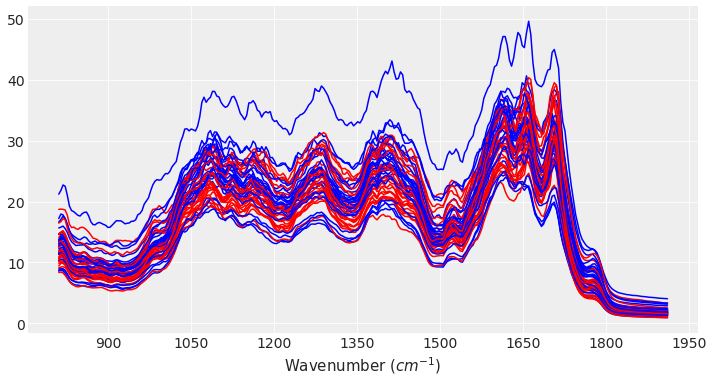

In [4]:
# name of column containing the labels
label_col = data_obj.label_column

# number of non-data columns at right of dataframe
non_data_cols = data_obj.non_data_columns

# list of class labels
class_labels = data_obj.get_class_labels()

# plot dataframe
utl.plot_data(data_obj, 50)

In [5]:
# number of samples from each class
data[label_col].value_counts()

Arabica    29
Robusta    27
Name: label, dtype: int64

In [6]:
# generate training and test sets
train_data, test_data = train_test_split(data, test_size=0.33, random_state=42)

# rename the index
test_data.index = range(len(test_data))
train_data.index = range(len(train_data))

In [7]:
test_data.shape

(19, 288)

In [8]:
train_data.shape

(37, 288)

# Model definition (Multiple Logistic Regression)
The following statistical model is assumed:

\begin{equation}
\alpha \sim \mathcal{N}(\mu_{\alpha},\,\sigma^{2}_{\alpha}) \\
\beta \sim \mathcal{N}(\mu_{\beta},\,\sigma^{2}_{\beta}) \\
\theta = logistic(\alpha+\beta X) \\
y \sim Bernoulli(\theta)
\end{equation}

In [9]:
# get Y labels and standardize the data
Y = pd.Categorical(train_data[label_col]).codes
x_n = train_data.columns[:non_data_cols]
x_s = train_data[x_n].values
x_s = utl.standardize(x_s)

In [10]:
with pm.Model() as model_mlr: 
    alpha = pm.Normal('alpha', mu=0, sd=10)
    beta = pm.Normal('beta', mu=0, sd=10, shape=len(x_n))
    
    mu = alpha + pm.math.dot(x_s, beta)
    theta = pm.Deterministic('theta', 1 / (1 + pm.math.exp(-mu))) 
     
    y_pred = pm.Bernoulli('y_pred', p=theta, observed=Y) 

    trace_mlr = pm.sample(2000, init='adapt_diag', random_seed=42)

Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta, alpha]
Sampling 2 chains: 100%|██████████| 5000/5000 [33:50<00:00,  2.46draws/s] 
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.


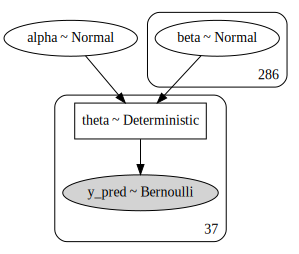

In [11]:
pm.model_to_graphviz(model_mlr)

# Model evaluation

In [12]:
varnames = ['alpha', 'beta']
coef = az.summary(trace_mlr, varnames)
coef

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
alpha,-3.589,7.470,-18.006,9.991,0.118,0.107,3983.0,2451.0,3982.0,2764.0,1.0
beta[0],-0.023,9.585,-17.891,18.024,0.137,0.154,4865.0,1947.0,4857.0,3002.0,1.0
beta[1],0.679,9.789,-17.086,20.253,0.139,0.173,4971.0,1596.0,4980.0,2511.0,1.0
beta[2],0.573,9.958,-16.881,19.541,0.148,0.182,4543.0,1497.0,4538.0,2588.0,1.0
beta[3],1.388,9.479,-16.486,18.834,0.142,0.158,4449.0,1796.0,4431.0,2456.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...
beta[281],-1.249,9.830,-19.267,17.338,0.138,0.177,5052.0,1551.0,5088.0,2522.0,1.0
beta[282],-1.353,9.945,-19.658,17.836,0.149,0.172,4478.0,1668.0,4467.0,2165.0,1.0
beta[283],-1.451,10.099,-20.227,17.039,0.150,0.170,4559.0,1763.0,4545.0,2760.0,1.0
beta[284],-1.524,9.712,-20.035,15.862,0.158,0.152,3801.0,2051.0,3789.0,2866.0,1.0


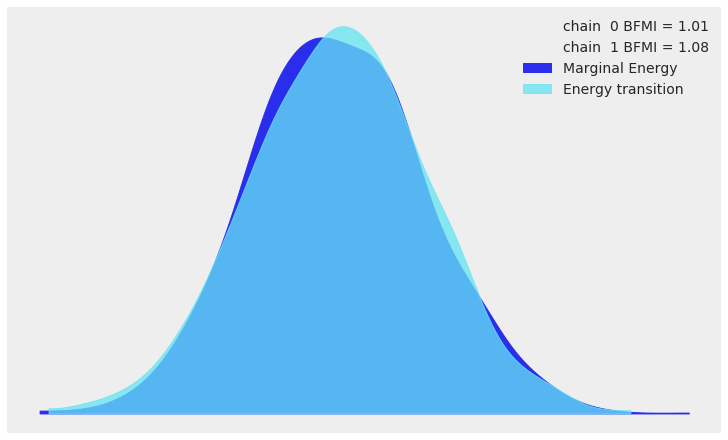

In [13]:
az.plot_energy(trace_mlr, figsize=(10, 6));

In [14]:
# check model predictions on test dataset
utl.display_predictions(data_obj, trace_mlr, test_data)

    code    label  pred pred_label
0      1  Arabica   0.0    Arabica
1      2  Robusta   1.0    Robusta
2      2  Robusta   1.0    Robusta
3      2  Robusta   1.0    Robusta
4      1  Arabica   0.0    Arabica
5      1  Arabica   0.0    Arabica
6      2  Robusta   1.0    Robusta
7      1  Arabica   0.0    Arabica
8      2  Robusta   1.0    Robusta
9      2  Robusta   1.0    Robusta
10     2  Robusta   1.0    Robusta
11     1  Arabica   0.0    Arabica
12     2  Robusta   1.0    Robusta
13     1  Arabica   0.0    Arabica
14     2  Robusta   1.0    Robusta
15     1  Arabica   0.0    Arabica
16     2  Robusta   1.0    Robusta
17     1  Arabica   0.0    Arabica
18     2  Robusta   1.0    Robusta


In [15]:
# prediction score on test dataset
utl.logistic_score(data_obj, test_data, test_data.iloc[:,-1])

total  : 19
correct: 19
error  : 0
score  : 100.0%


# Save inference results

In [16]:
pm.backends.text.dump('./traces/trace_coffees', trace_mlr)